# End to End Machine Learning Project

## Initalization: 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt 
import os
import numpy as np
import sklearn 
from sklearn.impute import SimpleImputer #Used to calculate and store median value for features
#from sklearn.preprocessing import OrdinalEncoder #to convert text into numbers( We will be using one hot encoding instead)
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.compose import TransformedTargetRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator,TransformerMixin

## Loading the Data and Displaying it to get an idea of the data loaded: 

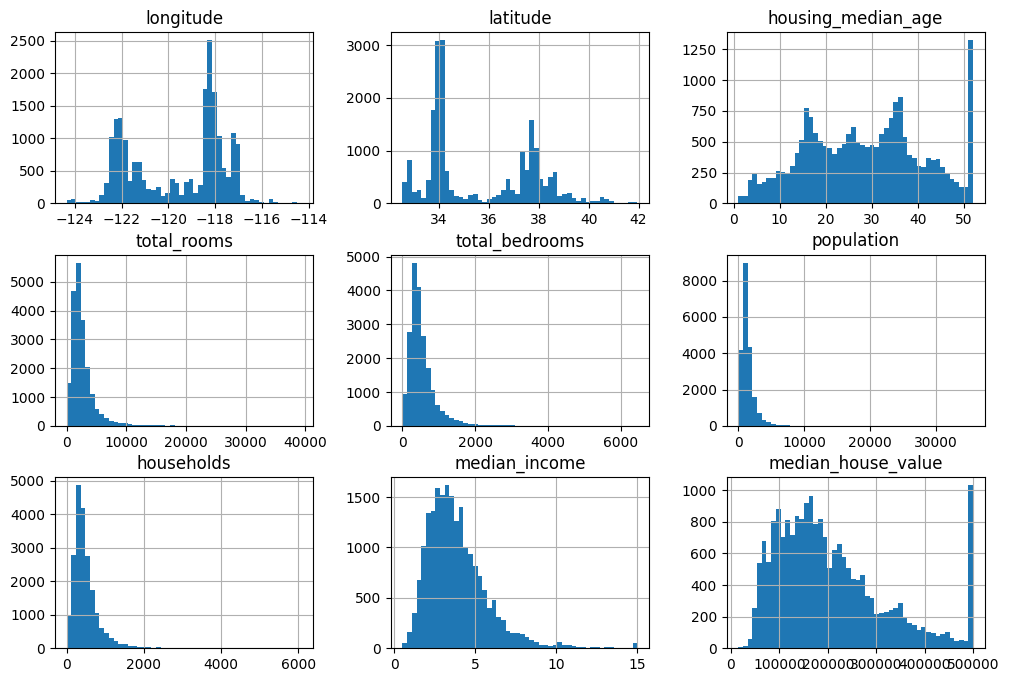

In [2]:
def load_housing_data(housing_path="datasets/housing"):
 csv_path = os.path.join(housing_path, "housing.csv") 
 return pd.read_csv(csv_path)
 

housing=load_housing_data() 
housing.head()
housing.hist(bins=50, figsize=(12, 8)) 
plt.show()

    

## Creating a training set by computing the hash function and using Longitude and Latitude as identifiers (optional): 

### We can instead use this simple line to generate a random test set

## We will however be using stratified sampling so the below code is the one we will use

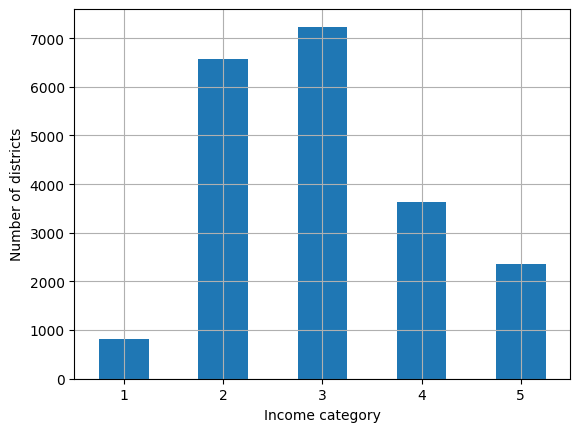

In [3]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5]) 

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True) 
plt.xlabel("Income category") 
plt.ylabel("Number of districts") 
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)
#For testing  
strat_test_set["income_cat"].value_counts() / len(strat_test_set) 
for set_ in (strat_train_set, strat_test_set): 
    set_.drop("income_cat", axis=1, inplace=True) # Deletes the temporary income_cat column

## Visualizing Geographical Data

<Axes: xlabel='longitude', ylabel='latitude'>

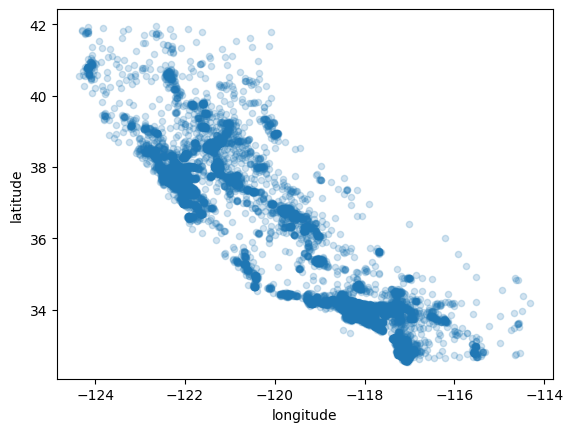

In [5]:
housing=strat_train_set.copy()
#housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter",x="longitude", y="latitude",alpha=0.2)

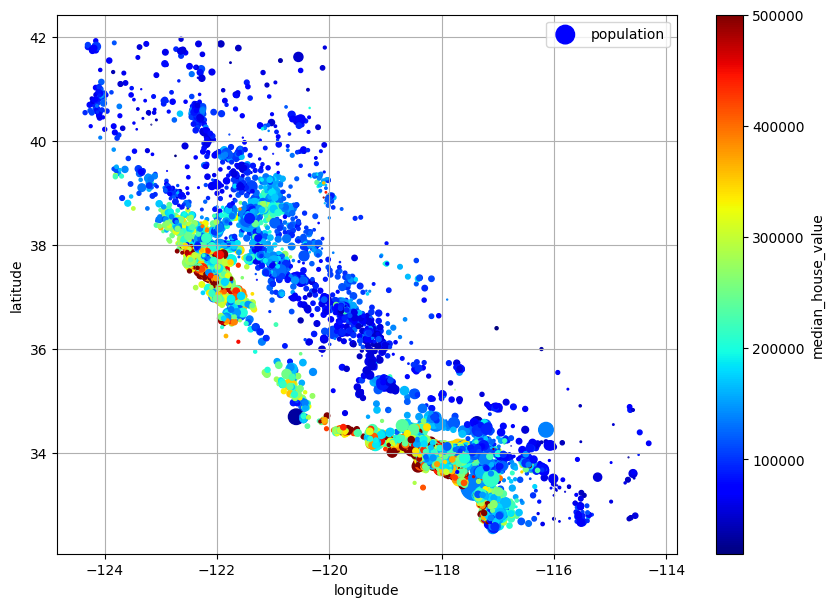

In [6]:
housing.plot(kind="scatter", x="longitude", y="latitude",
grid=True,
 s=housing["population"] / 100, label="population",
 c="median_house_value", cmap="jet", colorbar=True,
 legend=True, sharex=False, figsize=(10, 7))
plt.show()


## Code to computer Pearson's standard correlation coefficient

In [7]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)



median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

## Modifying attributes to make various attribute combinations and then calculating correlation matrix

In [8]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]
corr_matrix = housing.drop("ocean_proximity",axis=1).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
rooms_per_house       0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
people_per_house     -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_ratio       -0.259952
Name: median_house_value, dtype: float64

## Data Cleaning: 

In [9]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
imputer=SimpleImputer(strategy='median')
housing_num=housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
#imputer.statistics_     # Also Used to display the values stored in the statistics variable
housing_num.median().values
x=imputer.transform(housing_num) # replacing the missing values with median values. Applied to every column
housing_tr=pd.DataFrame(x,columns=housing_num.columns,index=housing_num.index) # Used to recover column names and index since x is outputted as a numpy array




## Handling Text and Categorical Attributes: 

### Using Ordinal Encoding:

In [12]:
# For viewing the ocean proxmity column
housing_cat=housing[["ocean_proximity"]]
#housing_cat.head(8) 

#Encoding the categories text into numbers
#ordinal_encoder=OrdinalEncoder() 
#housing_cat_encoded=ordinal_encoder.fit_transform(housing_cat)

#housing_cat_encoded[:8] # To display it after encoding
#ordinal_encoder.categories_   #To display the categories




### One-hot encoding:

In [13]:
cat_encoder=OneHotEncoder() #can be created with sparse=false which will return a dense numpy array directly
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)
housing_cat_1hot 
#Output of a onehotencoder is a sparse matrix which is an efficient representation for matrices that contain mostly zeroes.

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
# We can convert it into a Dense numpy array though using this:
housing_cat_1hot.toarray()

## Feature Scaling and Transformation: 

### Standardization

In [ ]:
std_scaler= StandardScaler=()
housing_num_std_scaled=std_scaler.fit_transform(housing_num)

### Applying Radial Basis Function

In [ ]:
age_simil_35= rbf_kernel(housing [["housing_median_age"]] , [[35]], gamma=0.1)

### Applying Transformation on Target/Output Data:

In [21]:
some_new_data=housing[["median_income"]].iloc[:5] # Taking this as new data for example's sake
model=TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(housing[["median_income"]],housing_labels)
predictions=model.predict(some_new_data)

### Custom Transformers 

In [28]:
#Defining the custom cluster function
class ClusterSimilarity(BaseEstimator, TransformerMixin): 
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None): 
        self.n_clusters = n_clusters 
        self.gamma = gamma 
        self.random_state = random_state 
 
    def fit(self, X, y=None, sample_weight=None): 
        self.kmeans_ = KMeans(self.n_clusters, 
random_state=self.random_state) 
        self.kmeans_.fit(X, sample_weight=sample_weight) 
        return self  # always return self! 
 
    def transform(self, X): 
        return rbf_kernel(X, self.kmeans_.cluster_centers_, 
gamma=self.gamma) 
 
    def get_feature_names_out(self, names=None): 
        return [f"Cluster {i} similarity" for i in 
range(self.n_clusters)]

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude","longitude"]], sample_weight=housing_labels)
similarities


C:\Users\bassa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[1.51803381e-13, 3.08925612e-01, 8.35196754e-04, ...,
        4.98378492e-16, 1.59544676e-01, 4.87598028e-01],
       [1.10147805e-01, 4.83759068e-22, 1.36374003e-08, ...,
        4.07332500e-01, 5.42668779e-18, 1.40930726e-16],
       [1.13222704e-01, 3.38820768e-08, 1.48874432e-01, ...,
        2.10893181e-02, 5.59389170e-06, 5.54903356e-05],
       ...,
       [2.48456214e-17, 6.34867318e-01, 1.96219378e-06, ...,
        2.05806050e-20, 1.39370410e-01, 3.62134062e-02],
       [9.07073621e-17, 7.32008884e-01, 3.48941956e-06, ...,
        8.11690737e-20, 1.91898354e-01, 4.50178051e-02],
       [4.16800221e-22, 1.24253321e-02, 2.13419186e-08, ...,
        3.46666225e-25, 6.27012814e-04, 2.52869175e-03]])